In [1]:
from data_utils import load_imdb, get_train_test_split

from copy import deepcopy
import os, sys, random, functools
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import numpy as np
from collections import Counter
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark = True

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from pytorch_pretrained_bert import BertModel, BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /home/jz288/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2022-12-18 20:28:36.012173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 20:28:36.150751: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-18 20:28:36.799824: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No suc

We note that this notebook is adapted from this online tutorial: https://www.kaggle.com/code/atulanandjha/bert-testing-on-imdb-dataset-extensive-tutorial

# load raw data and split it into train/test

In [2]:
x_train, x_test, y_train, y_test = get_train_test_split("IMDBDataset.csv", test_size=0.2)

length of train data is 40000
length of test data is 10000


# tokenizer

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# a custom pytorch dataset class

In [4]:
class IMDB(Dataset):
    def __init__(self, x, y, tokenizer, max_length=512) -> None:
        self.x = x
        self.y = y
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        tokens = ['[CLS]'] + tokenizer.tokenize(self.x[idx])[:self.max_length-2] + ['[SEP]']
        token_ids = tokenizer.convert_tokens_to_ids(tokens[:])
        
        label = 1 if self.y[idx] == 'positive' else 0
        return token_ids, label

    def __len__(self):
        return len(self.x)
    
def collate_fn(batch, max_length=512):
    batch_ids = [i[0] for i in batch]
    batch_ids = torch.from_numpy(
        pad_sequences(
            batch_ids,
            maxlen=max_length, truncating="post", 
            padding="post", dtype="int",
            value=0.0
        )
    )
    batch_labels = torch.LongTensor([i[1] for i in batch])
    # get the attention mask to avoid pad tokens (0)
    batch_masks = torch.FloatTensor(
        [[float(i > 0) for i in ids] for ids in batch_ids]
    )
    return batch_ids, batch_masks, batch_labels

# BERT classifier

In [7]:
class BERTClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BERTClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
    
    def forward(self, tokens, masks=None, freeze_bert=False):
        if freeze_bert:
            with torch.no_grad():
                _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
                dropout_output = self.dropout(pooled_output)
        else:
            _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
            dropout_output = self.dropout(pooled_output)
                    
        output = self.linear(dropout_output)
        return output

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(BERTClassifier())

109483778

# training setup

In [6]:
# hyperparams
batch_size = 32
max_length = 256
epochs = 5
num_train_samples = 40000
freeze_bert = False

train_set = IMDB(
    x_train[:num_train_samples], y_train[:num_train_samples], tokenizer, max_length)
test_set = IMDB(
    x_test, y_test, tokenizer, max_length)

train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, 
    collate_fn=lambda batch: collate_fn(batch, max_length)
)
test_loader = DataLoader(
    test_set, batch_size=200, shuffle=False,
    collate_fn=lambda batch: collate_fn(batch, max_length)
)

dropout = 0.4

bert_clf = BERTClassifier(dropout)
bert_clf = bert_clf.cuda()

if not freeze_bert:
    optimizer = optim.Adam(bert_clf.parameters(), lr=3e-6)
else:
    optimizer = optim.Adam(bert_clf.linear.parameters(), lr=1e-3)

# training

In [7]:
best_acc = 0.

for epoch_num in range(epochs):
    bert_clf.train()
    train_loss = 0.
    train_acc = 0
    
    for step_num, batch_data in tqdm(enumerate(train_loader), desc='Train', total=len(train_loader), leave=True):
        token_ids, masks, labels = tuple(t.cuda() for t in batch_data)
        logits = bert_clf(token_ids, masks)
        
        batch_loss = F.cross_entropy(logits, labels)
        train_loss += batch_loss.item()
        train_acc += logits.argmax(1).eq(labels).sum().item()
        
        bert_clf.zero_grad()
        batch_loss.backward()
        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)
    
    bert_clf.eval()
    test_loss = 0.
    test_acc = 0
    
    with torch.no_grad():
        for batch_data in tqdm(test_loader, total=len(test_loader), desc='Test', leave=True):
            token_ids, masks, labels = tuple(t.cuda() for t in batch_data)
            logits = bert_clf(token_ids, masks)

            batch_loss = F.cross_entropy(logits, labels)
            test_loss += batch_loss.item()
            test_acc += logits.argmax(1).eq(labels).sum().item()
        
    test_loss /= len(test_loader)
    test_acc /= len(test_loader.dataset)
    
    tqdm.write(f'epoch: {epoch_num+1}')
    tqdm.write(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
    tqdm.write(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')
    tqdm.write('-'*50)
    
    if test_acc >= best_acc:
        old_path = f'samples{args.num_samples}_epochs{args.epochs}_dropout{args.dropout:.1f}_acc{best_acc:.4f}.pth'
        try:
            Path(old_path).unlink()
        except FileNotFoundError:
            pass
        
        best_acc = test_acc
        torch.save(
            {
                'state_dict': bert_clf.state_dict(),
                'train_acc': train_acc,
                'train_loss': train_loss,
                'test_acc': test_acc,
                'test_loss': test_loss
            },
            f'samples{num_samples}_epochs{epochs}_dropout{dropout:.1f}_acc{best_acc:.4f}.pth'
        )
    

Test: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:41<00:00,  2.03s/it]


epoch: 1
train_loss: 0.500, train_acc: 0.765
test_loss: 0.300, test_acc: 0.879
--------------------------------------------------


Test: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:39<00:00,  1.99s/it]


epoch: 2
train_loss: 0.263, train_acc: 0.895
test_loss: 0.273, test_acc: 0.890
--------------------------------------------------


Test: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:41<00:00,  2.02s/it]


epoch: 3
train_loss: 0.210, train_acc: 0.919
test_loss: 0.260, test_acc: 0.899
--------------------------------------------------


Test: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:38<00:00,  1.97s/it]


epoch: 4
train_loss: 0.181, train_acc: 0.934
test_loss: 0.272, test_acc: 0.896
--------------------------------------------------


Test: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:32<00:00,  1.86s/it]

epoch: 5
train_loss: 0.148, train_acc: 0.946
test_loss: 0.299, test_acc: 0.900
--------------------------------------------------


# evaluation

In [8]:
bert_clf = BERTClassifier()
bert_clf.load_state_dict(
    torch.load('bert_checkpoints/samples40000_epochs5_dropout0.4_acc0.9211.pth')['state_dict'])
bert_clf = bert_clf.cuda()

In [9]:
max_length = 256

## real data

In [76]:
test_set = IMDB(
    x_test, y_test, tokenizer, max_length)

test_loader = DataLoader(
    test_set, batch_size=200, shuffle=False,
    collate_fn=lambda batch: collate_fn(batch, max_length)
)

## synthetic data

In [10]:
method = 'ngram' # bayes
reviews, sentiments = load_imdb(f"synthetic_data/{method}.csv")
test_set = IMDB(
    reviews, sentiments, tokenizer, max_length)

test_loader = DataLoader(
    test_set, batch_size=200, shuffle=False,
    collate_fn=lambda batch: collate_fn(batch, max_length)
)

In [11]:
bert_clf.eval()
test_loss = 0.
test_acc = 0
correct = []

with torch.no_grad():
    for batch_data in tqdm(test_loader, total=len(test_loader), desc='Test', leave=True):
        token_ids, masks, labels = tuple(t.cuda() for t in batch_data)
        logits = bert_clf(token_ids, masks)

        batch_loss = F.cross_entropy(logits, labels)
        test_loss += batch_loss.item()
        test_acc += logits.argmax(1).eq(labels).sum().item()
        
        correct.append(logits.argmax(1).eq(labels).cpu())

test_loss /= len(test_loader)
test_acc /= len(test_loader.dataset)
print(test_loss, test_acc)

Test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.46s/it]

0.4182905197143555 0.867


# qualitative examination

In [78]:
correct = torch.cat(correct)

In [79]:
indices = np.array([10,20,30])

num = 5
np.array(x_test)[correct.numpy().nonzero()[0][indices]]

array(["I found it real shocking at first to see William Shakespeare's love masterpiece reworked into a gory, violent and kinky sensual movie adaptation. But after you watched it once, it sort of grows on you when you watch it the second and third times, as you come over the shock and start appreciating the movie on its own merits - solid acting, good dialogue, nice sequencing and choreography, not-too-bad soundtrack and some of the (special) effects that go on. Oh, and also the ending. What a riot! eos",
       "The beginning of this movie had me doubting that it would be little more than a typical B sci-fi flick. But, as it progressed I began to get interested and I saw the whole thing through. The premise is interesting, original, and has the makings of making a classic. Alas, it instead ended up a mediocre movie, done in by the usual factors which turn a potentially good movie into a bad movie (bad acting, low budget etc.). I'm interested to see how this would turn out if it were r

In [80]:
np.array(y_test)[correct.numpy().nonzero()[0][indices]]

array(['positive', 'negative', 'negative'], dtype=object)

In [81]:
np.array(x_test)[1-correct.numpy().nonzero()[0][:num]]

array(["This movie is beautiful in all ways. It is visually stunning, and this is a good thing since the dialogue would only take up a page or two of paper. The acting is superb; it is subtle, passionate and intense. Ben Daniels does a fabulous job of turning himself into an animal, and mixing that wild nature with a man's overbearing passion and honor. There is not one flaw, not one mistake or wrong moment to be found anywhere. It is completely perfect, but only if you understand what you're going to experience. It isn't a movie for anyone who wants normality. eos",
       "I thought the film could be a bit more complex,in a psychological sense perhaps, but the action and voice acting were top notch. The animation was heavy CG in many scenes, but very good ones at that. This is one of the Batman Returns/Forever type films, which include romances and the conflicts of Wayne and motives for dating. 007 fans would love this, and so would the females, great theme song! Wayne was portrayed 

In [82]:
np.array(y_test)[1-correct.numpy().nonzero()[0][:num]]

array(['positive', 'positive', 'negative', 'negative', 'negative'],
      dtype=object)

# plot

In [22]:
file_list = [
    'samples4000_epochs5_dropout0.4_acc0.8903.pth',
    'samples8000_epochs5_dropout0.4_acc0.8997.pth',
    'samples20000_epochs5_dropout0.4_acc0.9097.pth',
    'samples40000_epochs5_dropout0.4_acc0.9211.pth'
]

train_acc = []
test_acc = []

for f in file_list:
    ckpt = torch.load(os.path.join('bert_checkpoints', f), map_location='cpu')
    train_acc.append(ckpt['train_acc'])
    test_acc.append(ckpt['test_acc'])

In [25]:
file_list = [
    'samples40000_epochs5_dropout0.1_acc0.9194.pth',
    'samples40000_epochs5_dropout0.2_acc0.9180.pth',
    'samples40000_epochs5_dropout0.3_acc0.9199.pth',
    'samples40000_epochs5_dropout0.4_acc0.9211.pth',
    'samples40000_epochs5_dropout0.5_acc0.9180.pth',
]

d_train_acc = []
d_test_acc = []

for f in file_list:
    ckpt = torch.load(os.path.join('bert_checkpoints', f), map_location='cpu')
    d_train_acc.append(ckpt['train_acc'])
    d_test_acc.append(ckpt['test_acc'])

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

[Text(0, 0, '0.890'),
 Text(0, 0, '0.900'),
 Text(0, 0, '0.910'),
 Text(0, 0, '0.921')]

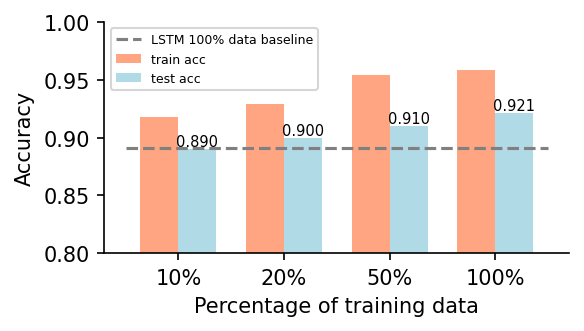

In [71]:
fig, ax = plt.subplots(1,1,figsize=(4,2),dpi=150)

width = 0.36
x = np.array(range(4))

ax.hlines(y=0.891, xmin=-0.5, xmax=3.5, color='gray', linestyle='dashed', label='LSTM 100% data baseline')

ax.bar(x-width/2, train_acc, width=width, label='train acc', color='lightsalmon', alpha=0.95)
bars = ax.bar(x+width/2, test_acc, width=width, label='test acc', color='lightblue', alpha=0.95)
ax.set_ylim(0.8, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['10%', '20%', '50%', '100%'])
ax.legend(fontsize=6)
ax.set_xlabel('Percentage of training data')
ax.set_ylabel('Accuracy')
ax.bar_label(bars, fmt='%.3f', fontsize=7)